In [1]:
# put the patches to the original images and store

import sys
import os
import os.path as osp
sys.path.insert(1, '/labs/gevaertlab/users/yyhhli/code/vae/')

In [2]:
vis_dir="/labs/gevaertlab/users/yyhhli/code/vae/EDA/image_synthesize_experiment/results/"
# load h5 file
import h5py

with h5py.File(osp.join(vis_dir, "stf_synth_imgs.h5"), "r") as f:
    print(f.keys())
    img_shrink = f['shrink'][:]
    img_enlarge = f['enlarge'][:]
    img_original = f['original'][:]
    smallest_idx = f['smallest_idx'][:]


<KeysViewHDF5 ['enlarge', 'original', 'shrink', 'smallest_idx']>


In [3]:
# convert spacing
from patch_extraction.preprocess_funcs import convert_spacing

In [4]:
smallest_idx

array([24, 76, 42, 38,  2, 11, 85, 50, 77,  5, 51,  1, 56, 83, 45,  0, 44,
       48, 36, 43, 59, 25, 35, 19, 29, 94, 53, 49, 84,  9, 72, 71, 37, 13,
       20, 99])

In [5]:
from utils.io import load_img
import SimpleITK as sitk

In [6]:
# load img np
def load_img_np(img_path, centroid=None):
    img_itk = load_img(img_path)
    img_itk, centroid = convert_spacing(img_itk, (1, 1, 1), centroid)
    img_np = sitk.GetArrayFromImage(img_itk).transpose((2, 1, 0))
    return img_np, centroid



In [7]:
# see the whole image from stf CT dataset
from cgitb import reset
from datasets import CT_DATASETS
stf_ds = CT_DATASETS["StanfordRadiogenomicsDataset"](reset_info=True)

# get the images from indexes
stf_imgs = []
stf_segs = []
centroid = []
centroid_is = []
centroid_ss = []
for idx in smallest_idx[:5]:
    print("loading: ", idx)
    pdict = stf_ds.get_info(int(idx))[1]['path']
    print(pdict)
    c = stf_ds.get_info(int(idx))[1]['centroid_dict']["0"]
    img_path, seg_path = pdict['img_path'], pdict['seg_path']
    img_np, centroid_i = load_img_np(img_path, c)
    seg_np, centroid_s = load_img_np(seg_path, c)
    print(centroid_i, centroid_s)
    stf_imgs.append(img_np)
    stf_segs.append(seg_np)
    centroid.append(c)
    centroid_is.append(centroid_i)
    centroid_ss.append(centroid_s)
    


/labs/gevaertlab/users/yyhhli/miniconda3/envs/lungvae38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Registering dataset: StanfordRadiogenomics


IndexError: list index out of range

In [ ]:
# print image shapes
for img in stf_imgs:    
    print(img.shape)

(410, 410, 376)
(309, 309, 288)
(394, 394, 322)
(456, 456, 395)
(480, 480, 360)


In [ ]:
s =stf_segs[0]

In [ ]:
np.sum(s == 0)

3189466

In [ ]:
import numpy as np
print(np.median(np.where(np.sum(s, axis=(0, 1)) > 0)))

128.0


In [ ]:
print(len(np.sum(s, axis=(0, 2))))

410


In [ ]:
# print seg shapes
import numpy as np
for i, seg in enumerate(stf_segs):
    print(seg.shape,"-- seg shape")
    # print the centroid of each segmentations 1s
    y = np.median(np.where(np.sum(seg, axis=(1, 2)) > 0))
    x = np.median(np.where(np.sum(seg, axis=(0, 2)) > 0))
    z = np.median(np.where(np.sum(seg, axis=(0, 1)) > 0))
    print(x, y, z, "-- seg centroid")
    print(centroid_ss[i], "-- centroid from dataset")
    print("\n")

(410, 410, 19) -- seg shape
128.0 290.5 9.0 -- seg centroid
[128 290   9] -- centroid from dataset


(310, 310, 288) -- seg shape
210.0 225.5 177.5 -- seg centroid
[211 226 178] -- centroid from dataset


(394, 394, 323) -- seg shape
216.0 113.5 246.5 -- seg centroid
[217 114 245] -- centroid from dataset


(456, 456, 395) -- seg shape
326.5 324.5 125.5 -- seg centroid
[326 325 127] -- centroid from dataset


(480, 480, 360) -- seg shape
250.5 368.5 178.0 -- seg centroid
[251 369 178] -- centroid from dataset




In [ ]:
# get the centroid coordinates for the lesions of these images
centroids = []
for idx in smallest_idx:
    centroid_dict = stf_ds.get_info(int(idx))[1]['centroid_dict']
    centroids.append(centroid_dict["0"])

In [ ]:
centroids

[array([159, 362,   9]),
 array([348, 374,  71]),
 array([281, 147,  98]),
 array([366, 364, 101]),
 array([267, 393, 142])]

In [ ]:
stf_ds.get_info('transpose_axis')

[0, 1, 2]

In [ ]:
# convert spacing
from patch_extraction.preprocess_funcs import convert_spacing

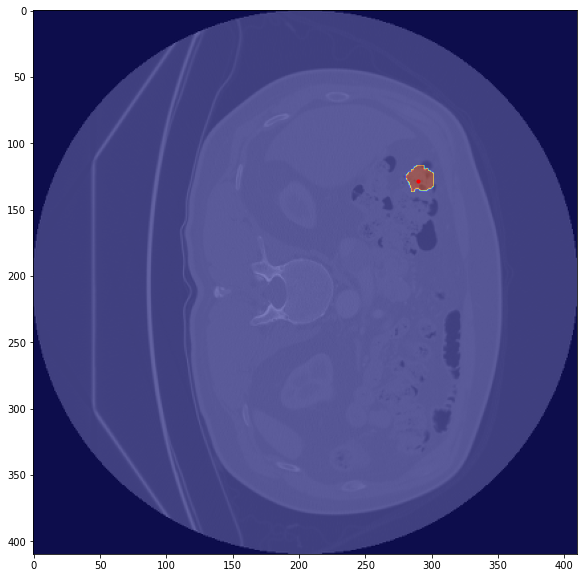

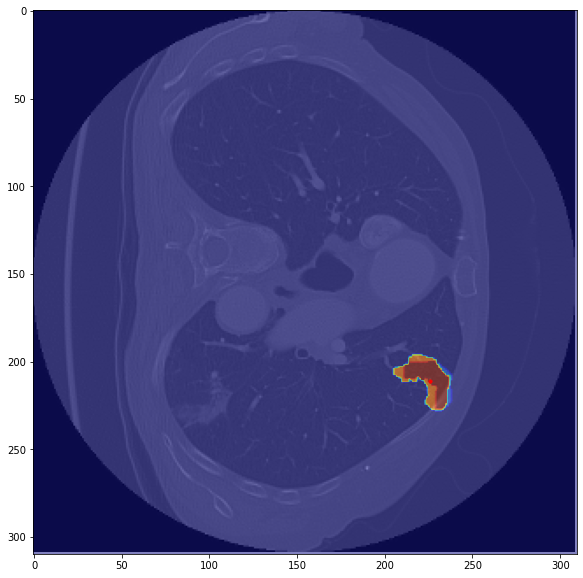

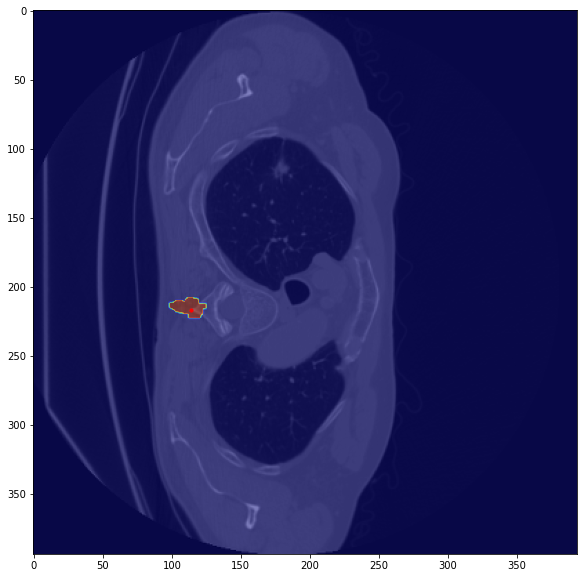

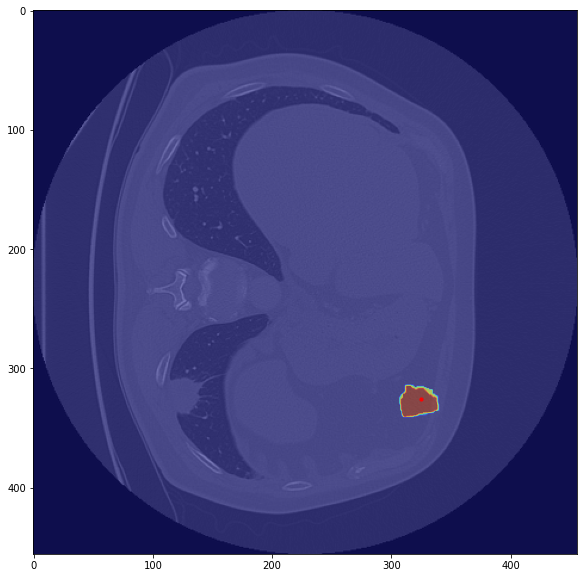

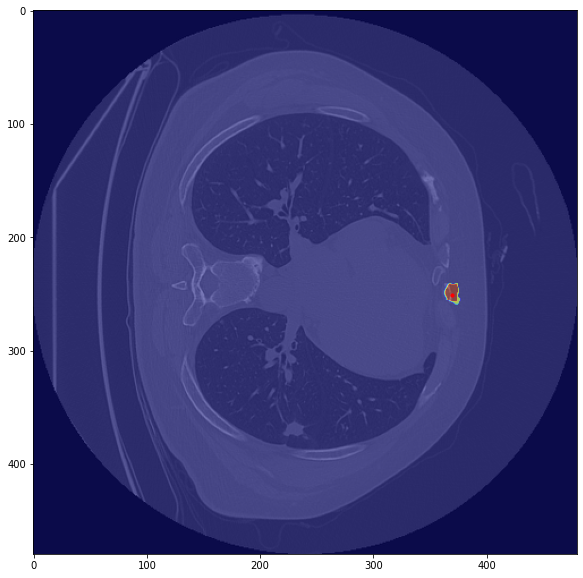

In [ ]:
# visualize the middle slice of the tumor of the image
# using centroid[2]

import matplotlib.pyplot as plt
import numpy as np

def plot_img(img, seg, centroid):
    # overlay seg with the image
    # plot the centroid as a dot 
    img = img[:,:,centroid[2]]
    seg = seg[:,:,centroid[2]]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    ax.imshow(seg, alpha=0.5, cmap='jet')
    ax.scatter(centroid[0], centroid[1], c='r', s=10)
    plt.show()

for img, seg, centroid in zip(stf_imgs, stf_segs, centroid_ss):
    seg = np.swapaxes(seg,0,1)
    centroid = [centroid[1], centroid[0], centroid[2]]
    plot_img(img, seg, centroid)

In [59]:
stf_ds.get_info('spacing')

[1, 1, 1]